# **Importation des données**

### Importation des bibliothèques

In [19]:
import kagglehub
import os
import shutil
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

### Importation des images depuis Kaggle

In [20]:
# Download latest version
path = kagglehub.dataset_download("danielvalyano/abstract-paintings")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'abstract-paintings' dataset.
Path to dataset files: /kaggle/input/abstract-paintings


In [23]:
"""folder_path = "/content/images"

if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print(f"Dossier supprimé")
else:
    print("Le dossier n'existe pas.")"""

Dossier supprimé


### Déplacement des images depuis route vers le répertoire courant

In [24]:
source_root = path + "/img"
target_root = "/content/images"

for root, dirs, files in os.walk(source_root):
    rel_path = os.path.relpath(root, source_root)
    target_dir = os.path.join(target_root, rel_path)

    os.makedirs(target_dir, exist_ok=True)

    for file in files:
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            shutil.copy(
                os.path.join(root, file),
                os.path.join(target_dir, file)
                )

# **Regroupement des images par ton de couleur**

### Détermination du nombre de groupes dans les données

In [25]:
IMAGE_DIR = "/content/images"
CLUSTER_OUTPUT = "/content/clusters"
IMG_SIZE = 128

In [26]:
#Détermination des couleurs dominantes
def dominant_color_hsv(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    pixels = img.reshape(-1, 3)

    filtered = pixels[pixels[:,1] > 3]

    if filtered.shape[0] < k:
        filtered = pixels

    kmeans = KMeans(n_clusters=3, n_init=10)
    labels = kmeans.fit_predict(filtered)

    counts = np.bincount(labels)
    dominant = kmeans.cluster_centers_[counts.argmax()]
    return dominant

In [27]:
# Chargement des images
image_paths = []
colors = []

for file in os.listdir(IMAGE_DIR):
    if file.lower().endswith(("jpg", "jpeg", "png")):
        path = os.path.join(IMAGE_DIR, file)
        image_paths.append(path)
        colors.append(dominant_color_hsv(path))

colors = np.array(colors)

In [28]:
#Détermination du nombre de clusters optimal avec l'agorithme du coude
K = range(2, 11)
sil_scores = []

#Standardisation des données
scaler = StandardScaler()
colors = scaler.fit_transform(colors)

for k in K:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(colors)
    score = silhouette_score(colors, labels)
    sil_scores.append(score)
    print(f"Pour {k} clusturs, silhouette = {score}")

# meilleur nombre de clusters
best_k = K[sil_scores.index(max(sil_scores))]
print(f"Nombre optimal de clusters : {best_k}")

Pour 2 clusturs, silhouette = 0.3395237242179146
Pour 3 clusturs, silhouette = 0.3905609655638688
Pour 4 clusturs, silhouette = 0.4101277573451337
Pour 5 clusturs, silhouette = 0.42572847532582225
Pour 6 clusturs, silhouette = 0.43775798667994426
Pour 7 clusturs, silhouette = 0.423976020437784
Pour 8 clusturs, silhouette = 0.36450437334353974
Pour 9 clusturs, silhouette = 0.36133351190189394
Pour 10 clusturs, silhouette = 0.3489417967042659
Nombre optimal de clusters : 6


### Regroupement

In [29]:
# Remise de colors dans l'échelle d'origine
colors = scaler.inverse_transform(colors)

In [31]:
FINAL_K = best_k

os.makedirs(CLUSTER_OUTPUT, exist_ok=True)

# Fonction de détermination des tons
def tone_classes(h, s, v):
    if v < 60:
        return "sombre"
    if s < 35:
        return "neutre"
    if s < 90:
        sat_label = "pastel"
    else :
        sat_label = "clair"
    if h < 45 or h > 160:
        temp_label = "chaud"
    else:
        temp_label = "froid"

    return f"{temp_label} {sat_label}"

#Modèle de Kmeans
kmeans = KMeans(n_clusters=FINAL_K, n_init=20, random_state=42)
labels = kmeans.fit_predict(colors)
centers = kmeans.cluster_centers_

# Attribution des tons aux clusters
cluster_names = {i: tone_classes(*centers[i]) for i in range(FINAL_K)}

# Regroupement des images
for path, label in zip(image_paths, labels):
    tone = cluster_names[label]
    target_dir = os.path.join(CLUSTER_OUTPUT, tone)
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(path, os.path.join(target_dir, os.path.basename(path)))

# Affichage résumé
print("Regroupement terminé")
print("Tons détectés :", set(cluster_names.values()))
print("\nRépartition par cluster :")
for i in range(FINAL_K):
    count = np.sum(labels == i)
    h, s, v = centers[i]
    print(f"Cluster {i} ({cluster_names[i]}): {count} images | H={h:.1f}, S={s:.1f}, V={v:.1f}")

Regroupement terminé
Tons détectés : {'froid pastel', 'neutre', 'froid clair', 'chaud pastel', 'chaud clair'}

Répartition par cluster :
Cluster 0 (chaud pastel): 969 images | H=27.1, S=73.6, V=87.3
Cluster 1 (froid pastel): 939 images | H=113.5, S=59.5, V=70.4
Cluster 2 (chaud clair): 1151 images | H=22.7, S=192.3, V=189.8
Cluster 3 (froid pastel): 1061 images | H=112.3, S=39.7, V=196.2
Cluster 4 (neutre): 2542 images | H=25.2, S=34.7, V=211.4
Cluster 5 (froid clair): 729 images | H=109.9, S=184.9, V=123.9


# Création du VAE

### Chargement des données

In [32]:
LATENT_DIM = 128
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 1e-3
CLUSTERS = {
    "chaud clair": 0,
    "chaud pastel": 1,
    "froid clair":   2,
    "froid pastel":   3,
    "neutre":  4
}
NUM_CLUSTERS = len(CLUSTERS)

In [33]:
# Chargement des données
def load_cluster_dataset(root_dir):
    images = []
    labels = []

    for cluster_name, cluster_id in CLUSTERS.items():
        cluster_path = os.path.join(root_dir, cluster_name)

        for fname in os.listdir(cluster_path):
            img_path = os.path.join(cluster_path, fname)
            img = keras.utils.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
            img = keras.utils.img_to_array(img) / 255.0
            images.append(img)
            labels.append([cluster_id])

    return np.array(images, dtype="float32"), np.array(labels, dtype="int32")


### Définition du VAE

In [34]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * eps

In [35]:
def build_encoder():
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = inputs
    for f in [32, 64, 128, 256]:
        x = layers.Conv2D(f, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
    z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    return keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")

In [36]:
def build_decoder():
    z_input = keras.Input(shape=(LATENT_DIM,))
    cluster_input = keras.Input(shape=(1,), dtype="int32")

    cluster_emb = layers.Embedding(NUM_CLUSTERS, LATENT_DIM)(cluster_input)
    cluster_emb = layers.Flatten()(cluster_emb)

    x = layers.Add()([z_input, cluster_emb])
    x = layers.Dense(8 * 8 * 256, activation="relu")(x)
    x = layers.Reshape((8, 8, 256))(x)

    for f in [128, 64, 32]:
        x = layers.Conv2DTranspose(f, 4, strides=2, padding="same", activation="relu")(x)

    outputs = layers.Conv2DTranspose(3, 4, strides=2, padding="same", activation="sigmoid")(x)
    return keras.Model([z_input, cluster_input], outputs, name="decoder")

In [37]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="loss")
        self.reco_loss_tracker = keras.metrics.Mean(name="reco_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self, x, training=False):
        _, _, z = self.encoder(x, training=training)
        batch = tf.shape(x)[0]
        dummy_labels = tf.zeros((batch, 1), dtype=tf.int32)
        return self.decoder([z, dummy_labels], training=training)

    @property

    def metrics(self):
        return [self.total_loss_tracker, self.reco_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        x, labels = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x, training=True)
            x_hat = self.decoder([z, labels], training=True)

            reco_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(x, x_hat),
                    axis=(1, 2)
                )
            )

            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(
                    1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                    axis=1
                )
            )

            total_loss = reco_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reco_loss_tracker.update_state(reco_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reco_loss": self.reco_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [38]:
def train_vae(cluster_path):
    images, labels = load_cluster_dataset(cluster_path)

    dataset = (
        tf.data.Dataset.from_tensor_slices((images, labels))
        .shuffle(len(images))
        .batch(BATCH_SIZE)
        .prefetch(tf.data.AUTOTUNE)
    )

    encoder = build_encoder()
    decoder = build_decoder()
    vae = VAE(encoder=encoder, decoder=decoder)
    vae.compile(optimizer=keras.optimizers.Adam(LEARNING_RATE))
    vae.fit(dataset, epochs=EPOCHS)

    return vae, encoder, decoder

### Entrainement

In [39]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU configuré avec memory growth")
    except RuntimeError as e:
        print(e)

GPU configuré avec memory growth


In [41]:
# Entraîner le VAE
vae, encoder, decoder = train_vae(CLUSTER_OUTPUT)

Epoch 1/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - kl_loss: 26.4148 - loss: 10689.4287 - reco_loss: 10663.0127
Epoch 2/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - kl_loss: 70.1560 - loss: 9636.4355 - reco_loss: 9566.2793
Epoch 3/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - kl_loss: 81.5487 - loss: 9460.4307 - reco_loss: 9378.8818
Epoch 4/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - kl_loss: 94.4285 - loss: 9293.4062 - reco_loss: 9198.9785
Epoch 5/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - kl_loss: 106.1952 - loss: 9146.3916 - reco_loss: 9040.1973
Epoch 6/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - kl_loss: 109.4921 - loss: 9088.6787 - reco_loss: 8979.1875
Epoch 7/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - kl_loss: 111.6722 - loss: 9020.5107 - reco_loss: 8908.8389
Epoch 8/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - kl_loss: 112.0914 - loss: 9023.7012 - reco_loss: 8911.6104
Epoch 9/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - kl_loss: 115.9605 - loss:

In [42]:
#Construction du modèle
dummy = tf.zeros((1, 128, 128, 3))
_ = vae(dummy)

In [43]:
vae.save("vae_model.h5")

### Génération de nouvelles images

In [44]:
def generate_images(decoder, cluster_name, n):
    if cluster_name not in CLUSTERS:
        raise ValueError(f"Cluster inconnu : {cluster_name}")

    z = np.random.normal(size=(n, LATENT_DIM))
    labels = np.full((n, 1), CLUSTERS[cluster_name], dtype=np.int32)
    images = decoder.predict([z, labels])

    fig, axes = plt.subplots(2, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.axis("off")
    plt.suptitle(f"Génération — {cluster_name}")
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step


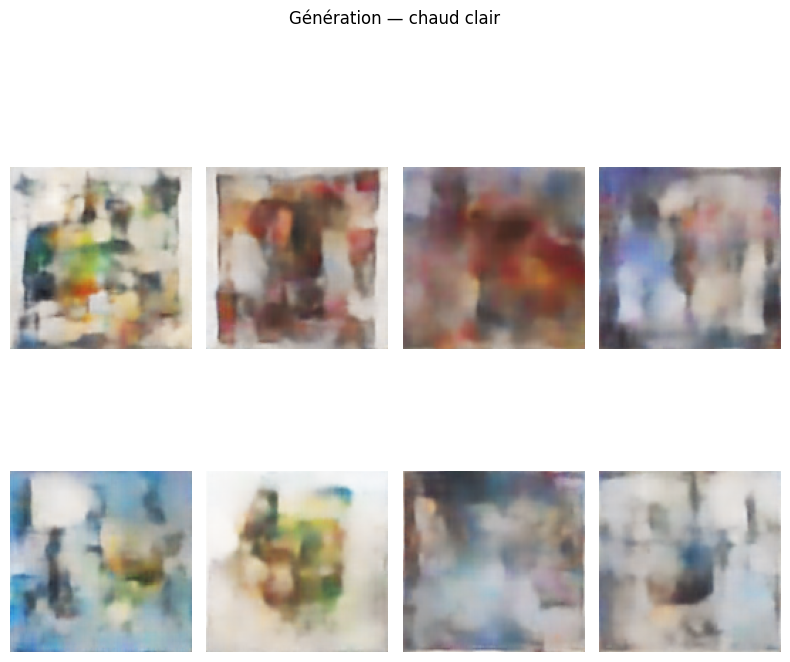

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


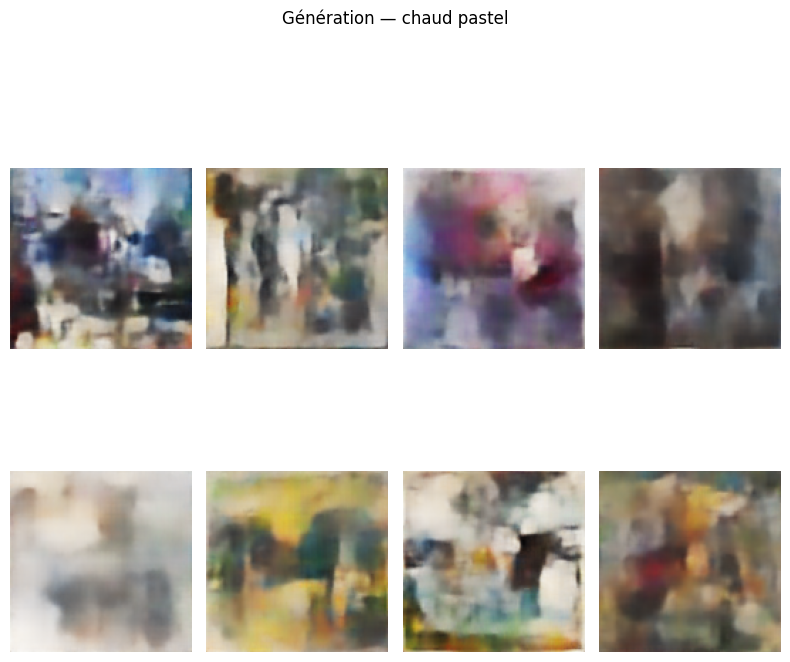

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


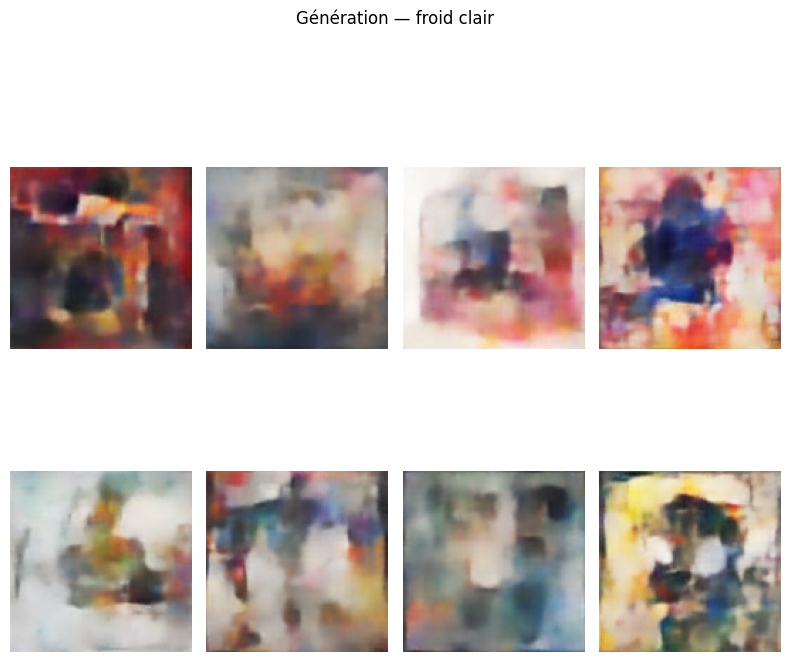

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


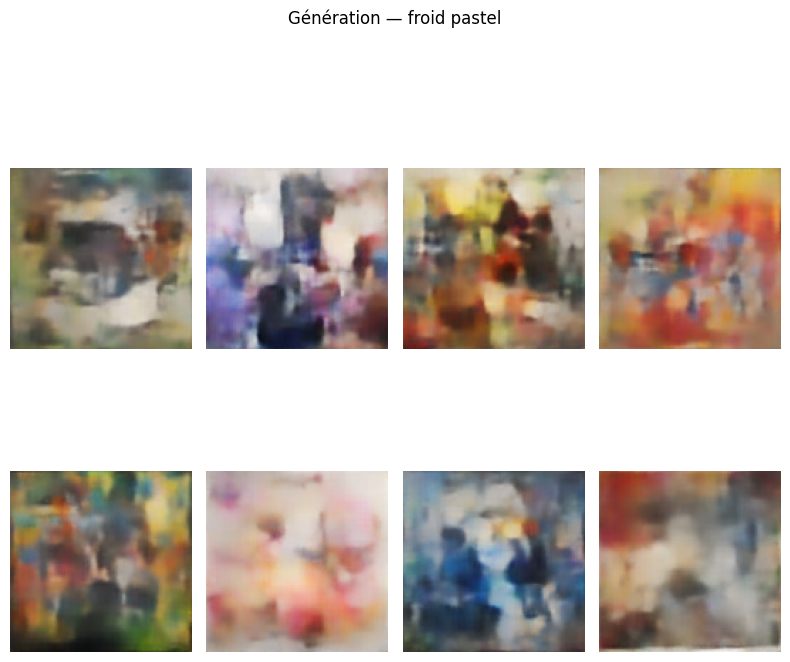

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


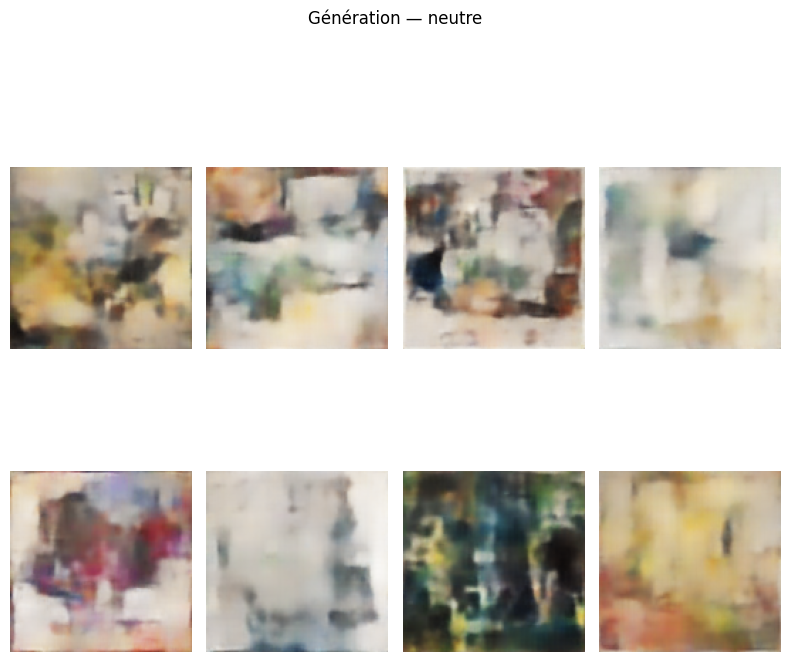

In [49]:
# Générer des images pour chaque cluster
for cluster_name in CLUSTERS.keys():
    generate_images(decoder, cluster_name, n=8)

### Téléchargement des fichiers de poids

In [53]:
from google.colab import files

files.download('vae_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
decoder.save("decoder.h5")
encoder.save("encoder.h5")

In [51]:
files.download('decoder.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
files.download('encoder.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>